### Loading the data

Transformations applied on the raw signal
- Applying Audio normalization
- Applying silence trimming

BIG NOTE: 
- Digital piano recordings were much quieter: the average DB level difference between digital and grand piano was > 20 dB.  
- Therefore, Audio normalization significantly amplified the sound of digital piano to make it similar in volume to other sound files
- This amplification not only increased the signal, but also significantly increased the noise. Therefore, analysis of how different "digital" and "real" piano sounds are may have been affected by different amount of noise in the sound files
- Next time during the recording "average sound level" should be checked. This will ensure approximately same loudness and no need for unequal amplification

In [0]:
# pip install pydub ffmpeg      --- required
# sudo apt-get install ffmpeg   --- optional
from pydub import AudioSegment 

def match_target_amplitude(sound, target_dBFS=-14): # default YouTube audio normalization level
    '''
    https://stackoverflow.com/questions/42492246/how-to-normalize-the-volume-of-an-audio-file-in-python-any-packages-currently-a
    '''
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


def detect_leading_silence(sound, silence_threshold=-25.0, chunk_size=50):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms
    iterate over chunks until you find the first one with sound
    https://stackoverflow.com/questions/29547218/remove-silence-at-the-beginning-and-at-the-end-of-wave-files-with-pydub
    '''
    trim_ms = 0 # ms
    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

def trim_silence(sound, silence_threshold=-50, chunk_size=10):
    start_trim = detect_leading_silence(sound)
    end_trim = 0 # <- Do not trim the end   For trimming -> #detect_leading_silence(sound.reverse())
    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    return trimmed_sound

In [17]:
import os
import numpy
from scipy.io import wavfile

def get_features(filepath):
    sound = AudioSegment.from_wav(filepath)
    sound = match_target_amplitude(sound)
    sound = trim_silence(sound, chunk_size=50) # treat noise peaks as silence (large window)
    return numpy.array(sound.get_array_of_samples())[:44100 * 2].reshape(1, -1) # 2 seconds

def load_data(data_path="../data/recordings/"):
    label_prefixes = {"C_El": 0, # grand
                      "G_El": 1, # grand
                      "C_Er": 2, # digital
                      "G_Er": 3} # digital
    labels = None
    features = None
    for filename in os.listdir(data_path):
        current_label = label_prefixes[filename[:4]]
        current_features = get_features(os.path.join(data_path, filename))
        if labels is None:
            labels = numpy.array(current_label)
            features = current_features
        else:
            labels = numpy.append(labels, current_label)
            features = numpy.vstack((features, current_features))
    return features, labels
features, labels = load_data()
print("Sample data:\nLabel: {}\nFeatures: {}".format(labels[4], features[4]))

Sample data:
Label: 1
Features: [  1636500   2906812   6162207 ... -21436111 -26988462 -30494204]


### Plotting example waveforms

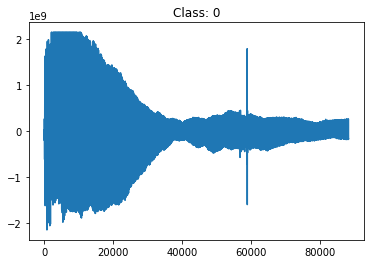

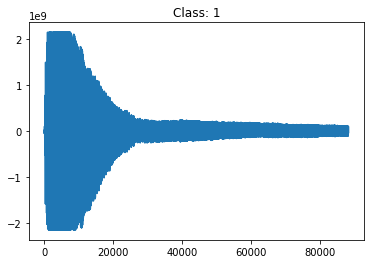

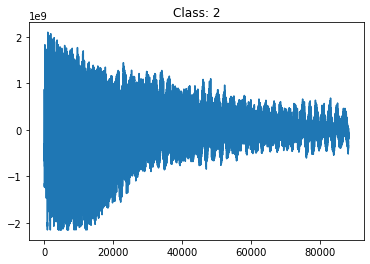

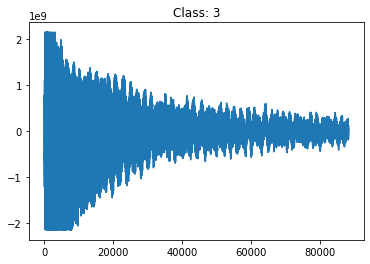

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

for class_id in range(4):
    example = features[labels == class_id][1] # first example of this class
    plt.figure()
    plt.plot(example)
    plt.title("Class: {}".format(class_id))

### Plotting example spectrograms

We can see more noise in digital piano recordings

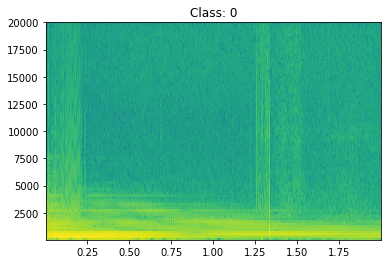

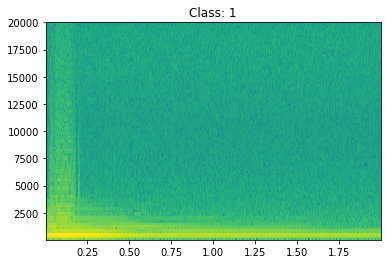

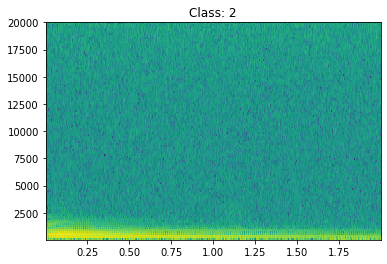

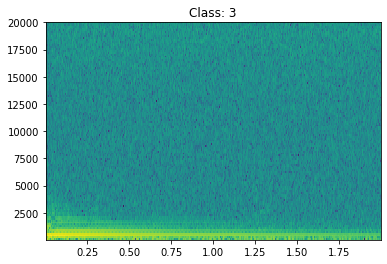

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

for class_id in range(4):
    example = features[labels == class_id][1] # first example of this class
    plt.figure()
    plt.specgram(example, Fs=44100, NFFT=256, noverlap=128, Fc=0)
    #plt.yscale("log")
    plt.ylim(20, 20000) # audible frequencies
    plt.title("Class: {}".format(class_id))


### Classification of Real and Digital piano sounds

Classification accuracy is surprisingly good. No need to do any pre-processing, just raw features work. Again, perhaps noise allows to classify digital piano easier.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

labels_binary = numpy.where(labels < 2, 0, 1) # 0 for real, 1 for digital

print(features.shape)
print(labels.shape)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels_binary)
#model = LogisticRegression(solver="lbfgs", multi_class="multinomial") # use multinomial for > 2 classes
model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', early_stopping=False)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print("Training accuracy:", accuracy_score(Y_train, Y_train_pred))
print("Testing accuracy:", accuracy_score(Y_test, Y_test_pred))

(132, 88200)
(132,)
Training accuracy: 1.0
Testing accuracy: 0.9090909090909091


### Analysis of how the sound information is different

The results below are counter-intuitive, I would expect digital piano sound to have less principal components. Perhaps too much noise in digital piano recordings affected the results

In [21]:
# Checking for number of significant principal components (how many >1% = 0.01 variance components are in the list)
from sklearn.decomposition import PCA
model = PCA()
for class_id in range(4):
    class_features = features[labels == class_id]
    model.fit(class_features)
    importance = model.explained_variance_ratio_[model.explained_variance_ratio_ > 0.01]
    print("Class {}: principal components (total = {}) importance: {}".format(class_id, len(importance), importance))

Class 0: principal components (total = 4) importance: [0.38179371 0.25148807 0.17302534 0.13797166]
Class 1: principal components (total = 3) importance: [0.5338712  0.4092595  0.01303221]
Class 2: principal components (total = 15) importance: [0.26566232 0.16900167 0.10921973 0.07666154 0.06720668 0.05158268
 0.04195431 0.03368284 0.02691938 0.02616883 0.01905238 0.0171993
 0.0126002  0.01170212 0.01090608]
Class 3: principal components (total = 15) importance: [0.2968259  0.23902057 0.09852977 0.08491758 0.04039707 0.02711856
 0.02434009 0.02253411 0.02016634 0.01666883 0.01628172 0.01303373
 0.01234359 0.01195005 0.01053358]


Here below the results are as expected: Grand piano results in smooth distribution, while digital piano has noisy distribution

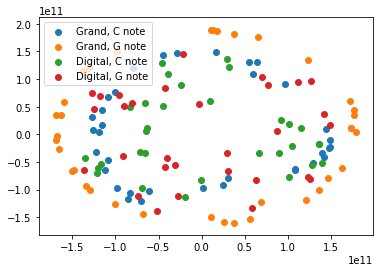

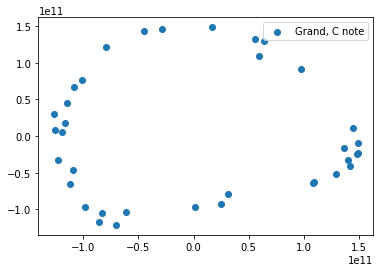

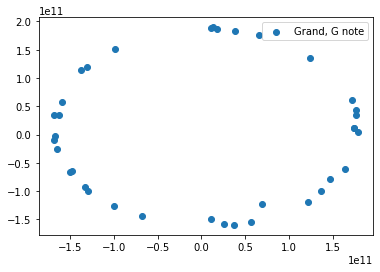

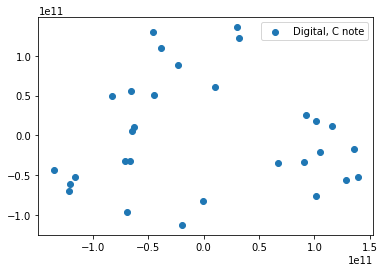

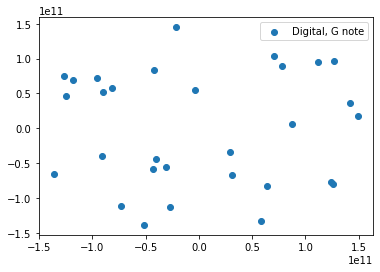

In [22]:
# Plotting with PCA
def plot_components(components, labels, separate=False):
    plt.figure()
    plt.scatter(components[labels==0, 0], components[labels==0, 1], label="Grand, C note")
    if separate: 
        plt.legend()
        plt.figure()
    plt.scatter(components[labels==1, 0], components[labels==1, 1], label="Grand, G note")
    if separate: 
        plt.legend()
        plt.figure()
    plt.scatter(components[labels==2, 0], components[labels==2, 1], label="Digital, C note")
    if separate: 
        plt.legend()
        plt.figure()
    plt.scatter(components[labels==3, 0], components[labels==3, 1], label="Digital, G note")
    plt.legend()
    
model = PCA(n_components=2)
features_pca = numpy.zeros((len(features), 2)) # placeholder for separate pca results
for class_id in range(4):
    features_pca[labels==class_id] = model.fit_transform(features[labels==class_id])
plot_components(features_pca, labels)
plot_components(features_pca, labels, separate=True)

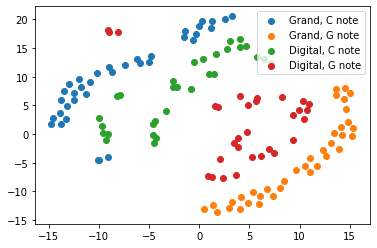

In [23]:
# Plotting with T-SNE
# Expecting four clusters; will some cluster, will some clusters be discretized?

from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=20) # try different perplexities 10..50 for different views
features_tsne = model.fit_transform(features)
plot_components(features_tsne, labels)